# Variational AutoEncoder (VAE)

In [1]:
# Bisogna testare tutto passo passo
# Train Validation Test? Intendo, ci interessa la performance su dati Mai Visti?
# Indagare #e loss e ottimizzatori
# Il modo in cui hanno fatto l'autoencoder al tutorato NN ha prior sl latent space...

In [2]:
import torch
from torch import nn
from torch import optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Hyperparameters

In [3]:
BATCH_SIZE = 32

## Architecture parameters
IMAGE_DIM = 28*28
LATENT_DIM = 2
HIDDEN_DIM = 256

## Training setup
LR = 1e-4
WEIGHT_DECAY = 1e-6
EPOCHS = 20

## Dataset download and setup

In [4]:
# work on GPUs
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [5]:
## Import Dataset (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),                             
    # <-- we dont normalize here, can you guess why?
])

train_dataset = torchvision.datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
validation_dataset = torchvision.datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

In [6]:
## Reduce dataset size
# N_TRAIN = 1000
# train_dataset.data, train_dataset.targets = train_dataset.data[:N_TRAIN], train_dataset.targets[:N_TRAIN]
# validation_dataset.data, validation_dataset.targets = validation_dataset.data[:N_TRAIN], validation_dataset.targets[:N_TRAIN]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False)

## Dataset visualization

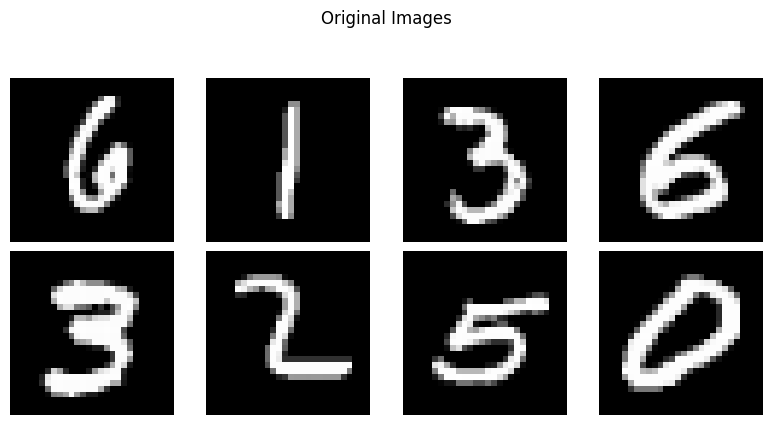

In [7]:
## Plotting utility
def plot_images(images, title):
    plt.figure(figsize=(8, 4)) # they're inches...
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title, y=1.05)
    plt.tight_layout()


## Visualize sample from dataset
with torch.no_grad():
    idx, (images, _) = next(enumerate(train_loader))

plot_images(images, title="Original Images")
plt.show()

## Model and Training

In [8]:
## Build model
class VAE(nn.Module):
    def __init__(self, input_dim, out_dim, latent_dim, hidden_dim=200):
        super().__init__()

        self.latent_dim = latent_dim
        
        ## Utilities
        self.flatten = nn.Flatten(1,3)
        self.activation = nn.ReLU()

        ## Encoder
        self.input2encoder_hid = nn.Linear(input_dim, hidden_dim)
        self.encoder_hid2mu = nn.Linear(hidden_dim, latent_dim)
        self.encoder_hid2sigma = nn.Linear(hidden_dim, latent_dim)
        
        ## Decoder
        self.latent2decoder_hid = nn.Linear(latent_dim, hidden_dim)
        self.decoder_hid2sigm = nn.Linear(hidden_dim, out_dim)

        ## Out
        self.sigmoid = nn.Sigmoid()
        self.unflatten = nn.Unflatten(1, (1, 28, 28)) ## qua è rimasto 28...

    def encode(self, x):
        x = self.flatten(x)
        x = self.input2encoder_hid(x)
        x = self.activation(x)
        
        ## mu e sigma nn prendono nessuna activation (?)
        mu    = self.encoder_hid2mu(x)
        sigma = self.encoder_hid2sigma(x)
        
        ## DEBUG
        # print(latent_param.size())
        # print(latent_param)
        
        return mu, sigma

    def decode(self, mu, sigma):
        ## Sampling from a gaussian
        eps = torch.randn(self.latent_dim, requires_grad=False)
        
        ## Reparametrization
        z = mu + sigma*eps  

        ## Decode
        z = self.latent2decoder_hid(z)
        z = self.activation(z)
        z = self.decoder_hid2sigm(z)
        x_gen = self.sigmoid(z)
        x_gen = self.unflatten(x_gen)

        return x_gen

    def forward(self, x):
        mu, sigma = self.encode(x)
        x_gen = self.decode(mu, sigma)

        return x_gen, mu, sigma

In [9]:
## Loss definition
def loss(x, x_gen, mu, sigma):
    D_kl = torch.log(sigma*sigma) - mu*mu - sigma*sigma
    mse  = (x-x_gen)*(x-x_gen)

    ## DEBUG
    # print(D_kl.size())
    # print(mse.size())
    
    ## Average on minibatch, sum over latent dimenions
    D_kl = D_kl.mean(dim=0)
    D_kl = D_kl.sum()
    
    ## Average on minibatch, Sum over pixels
    mse  = mse.mean(dim=0)
    mse  = mse.sum() 
    # mse /= len(mse)
    
    return mse - D_kl 



In [10]:
model = VAE(IMAGE_DIM, IMAGE_DIM, LATENT_DIM)
model = model.to(DEVICE)

## Optimizer choice
optimizer = optim.Adam(model.parameters(),
                      lr = LR,
                      weight_decay=WEIGHT_DECAY)

## Model summary
# print(model.parameters)

### Training

In [ ]:
# train loop
loss_train = []
loss_validation = []

for epoch in range(EPOCHS):
    loss_epoch = 0.0
    for x_train, _ in train_loader:
        x_train = x_train.to(DEVICE)
        
        x_gen, mu, sigma = model(x_train) # in qlche modo qua sa che deve andare a prendere .forward()
        computed_loss = loss(x_gen, x_train, mu=mu, sigma=sigma)
        loss_epoch += computed_loss.detach()
        
        optimizer.zero_grad()
        computed_loss.backward()
        optimizer.step()

    ## Loss record
    loss_epoch /= len(train_loader)
    loss_train.append(loss_epoch)

    with torch.no_grad():
        for x_val, _ in validation_loader:
            x_val = x_val.to(DEVICE)
            
            x_gen_val, mu, sigma = model(x_val)
            val_computed_loss = loss(x_gen_val, x_val, mu=mu, sigma=sigma)
            loss_validation.append(val_computed_loss.detach())
            
    print(f"Epoch: {epoch+1:2.0f} -- Train loss = {computed_loss:.5f} -- Val loss = {val_computed_loss:.5f}")

Epoch:  1 -- Train loss = 53.84575 -- Val loss = 55.36156
Epoch:  2 -- Train loss = 53.16031 -- Val loss = 50.83107
Epoch:  3 -- Train loss = 49.64509 -- Val loss = 48.89457
Epoch:  4 -- Train loss = 57.25161 -- Val loss = 47.31519
Epoch:  5 -- Train loss = 47.56900 -- Val loss = 48.61487
Epoch:  6 -- Train loss = 43.16004 -- Val loss = 47.25612
Epoch:  7 -- Train loss = 45.23670 -- Val loss = 49.44234
Epoch:  8 -- Train loss = 43.14000 -- Val loss = 46.07226
Epoch:  9 -- Train loss = 45.86998 -- Val loss = 45.80396
Epoch: 10 -- Train loss = 49.46217 -- Val loss = 48.25381
Epoch: 11 -- Train loss = 48.93005 -- Val loss = 48.14844
Epoch: 12 -- Train loss = 49.18661 -- Val loss = 49.86371
Epoch: 13 -- Train loss = 43.64188 -- Val loss = 45.97247
Epoch: 14 -- Train loss = 53.67721 -- Val loss = 49.13425
Epoch: 15 -- Train loss = 45.29675 -- Val loss = 46.01184
Epoch: 16 -- Train loss = 51.95596 -- Val loss = 46.68651


### Visualization

In [ ]:
## Train and validation loss curves
plt.plot(loss_train, label = "Train")
plt.plot(loss_validation, label = "Validation")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

In [ ]:
image_iterator = enumerate(train_loader)

In [ ]:
## Compare actual figures
with torch.no_grad():
    idx, (images, _) = next(image_iterator)
    images_gen, mu, sigma = model(images)
    

plot_images(images, title="Original Images")
plot_images(images_gen, title="Generated Images")
plt.show()

In [ ]:
## Sample from latent space
## Generate